# Required Libs

In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, recall_score, 
    f1_score, roc_curve, auc, confusion_matrix)

## EDA

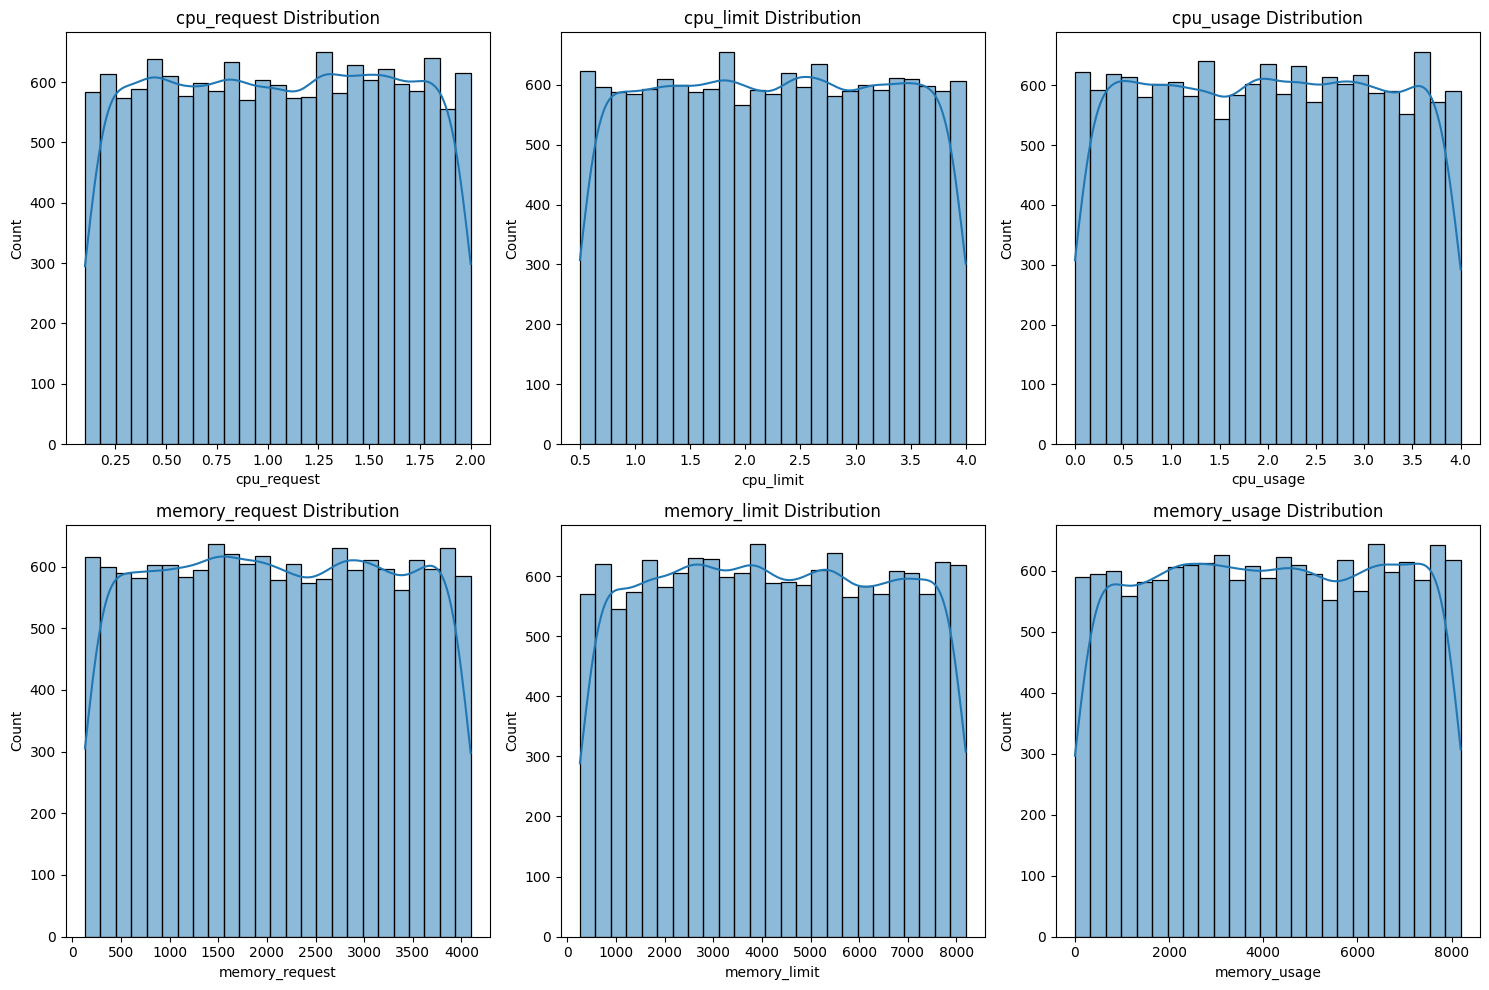

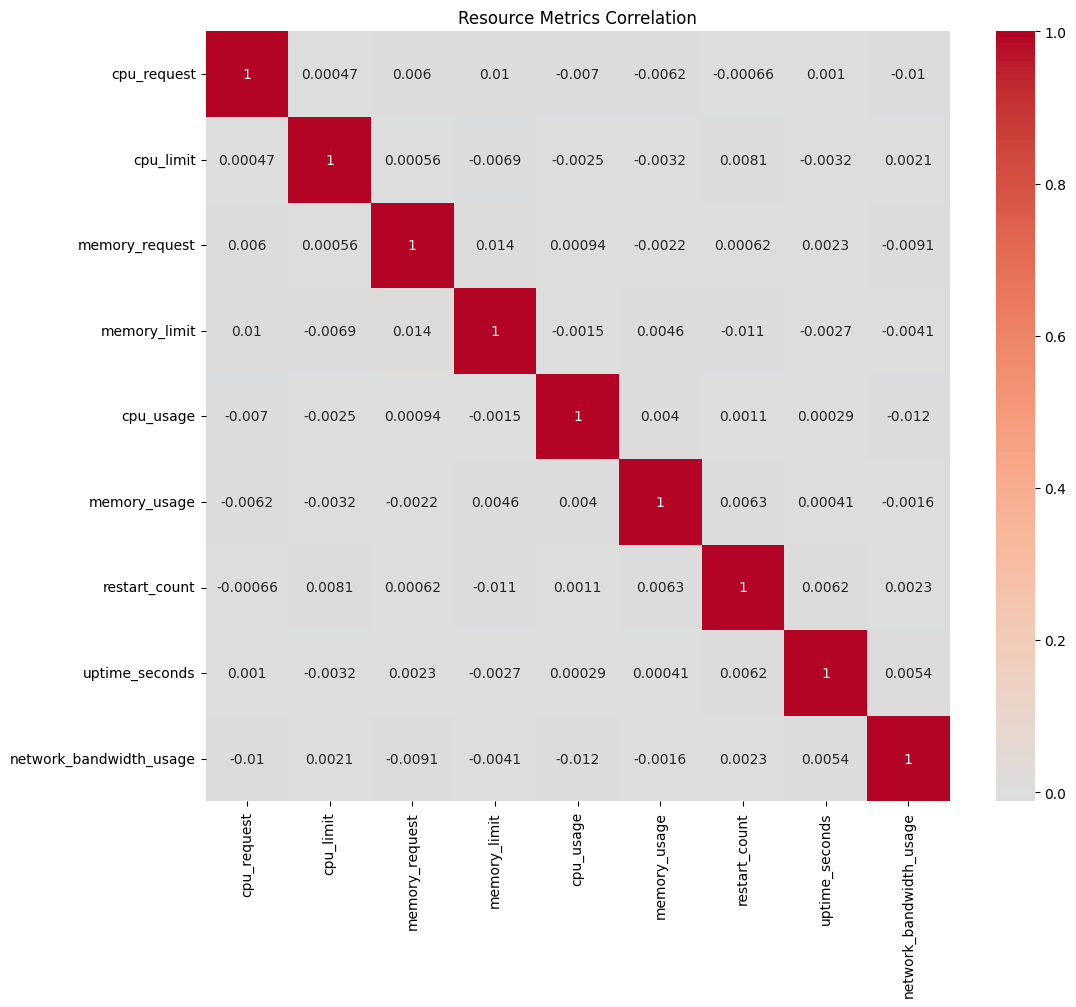

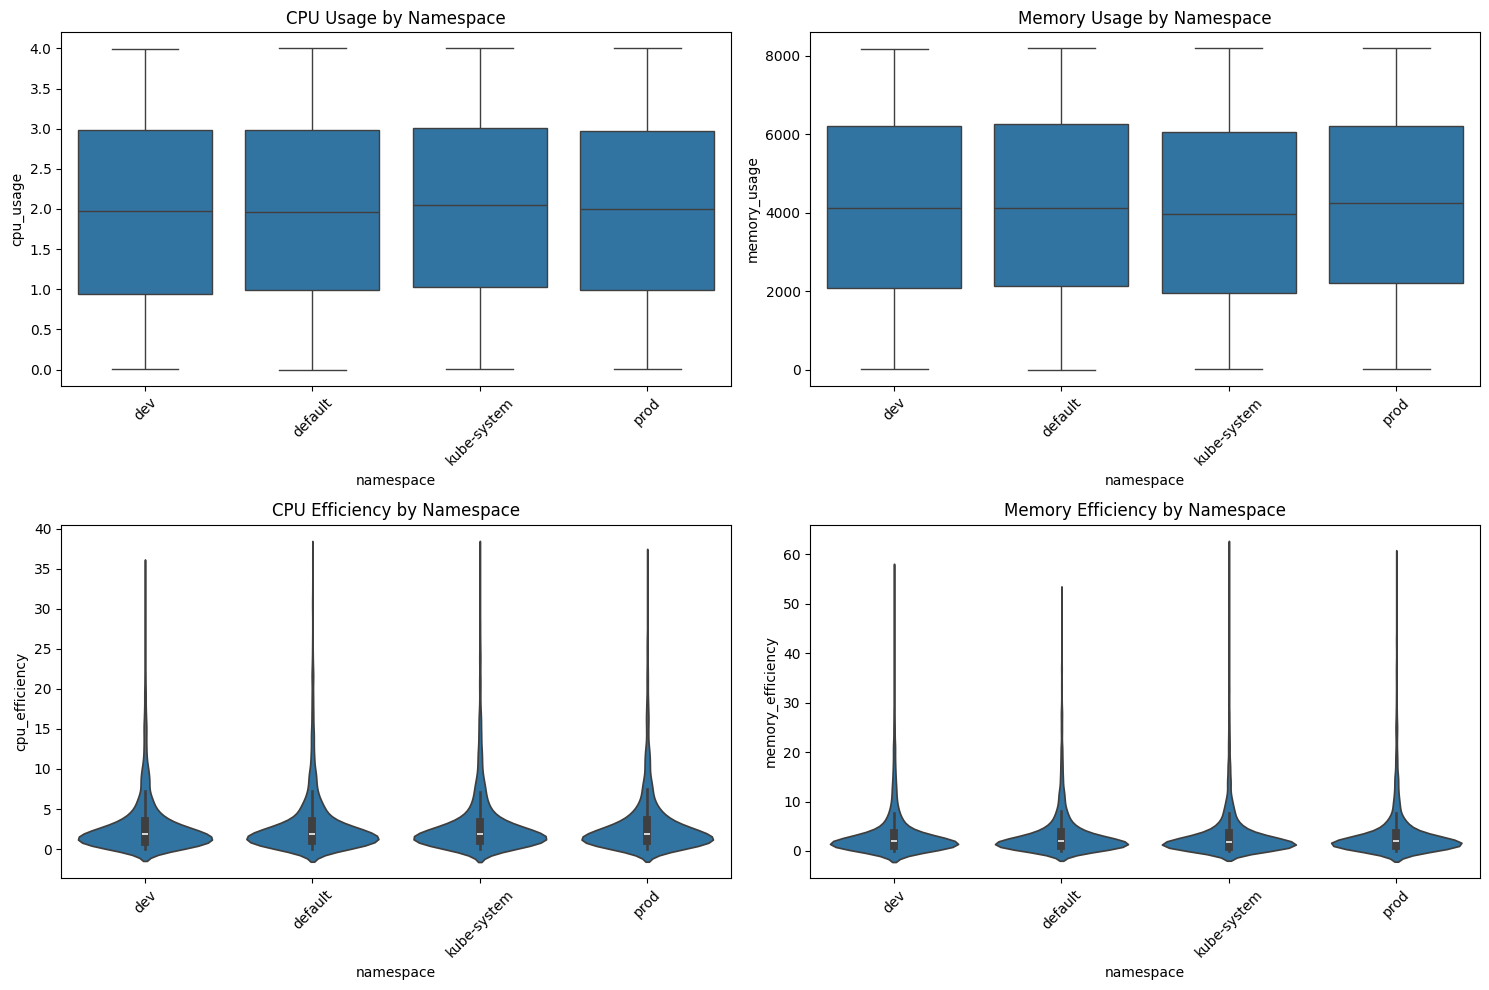

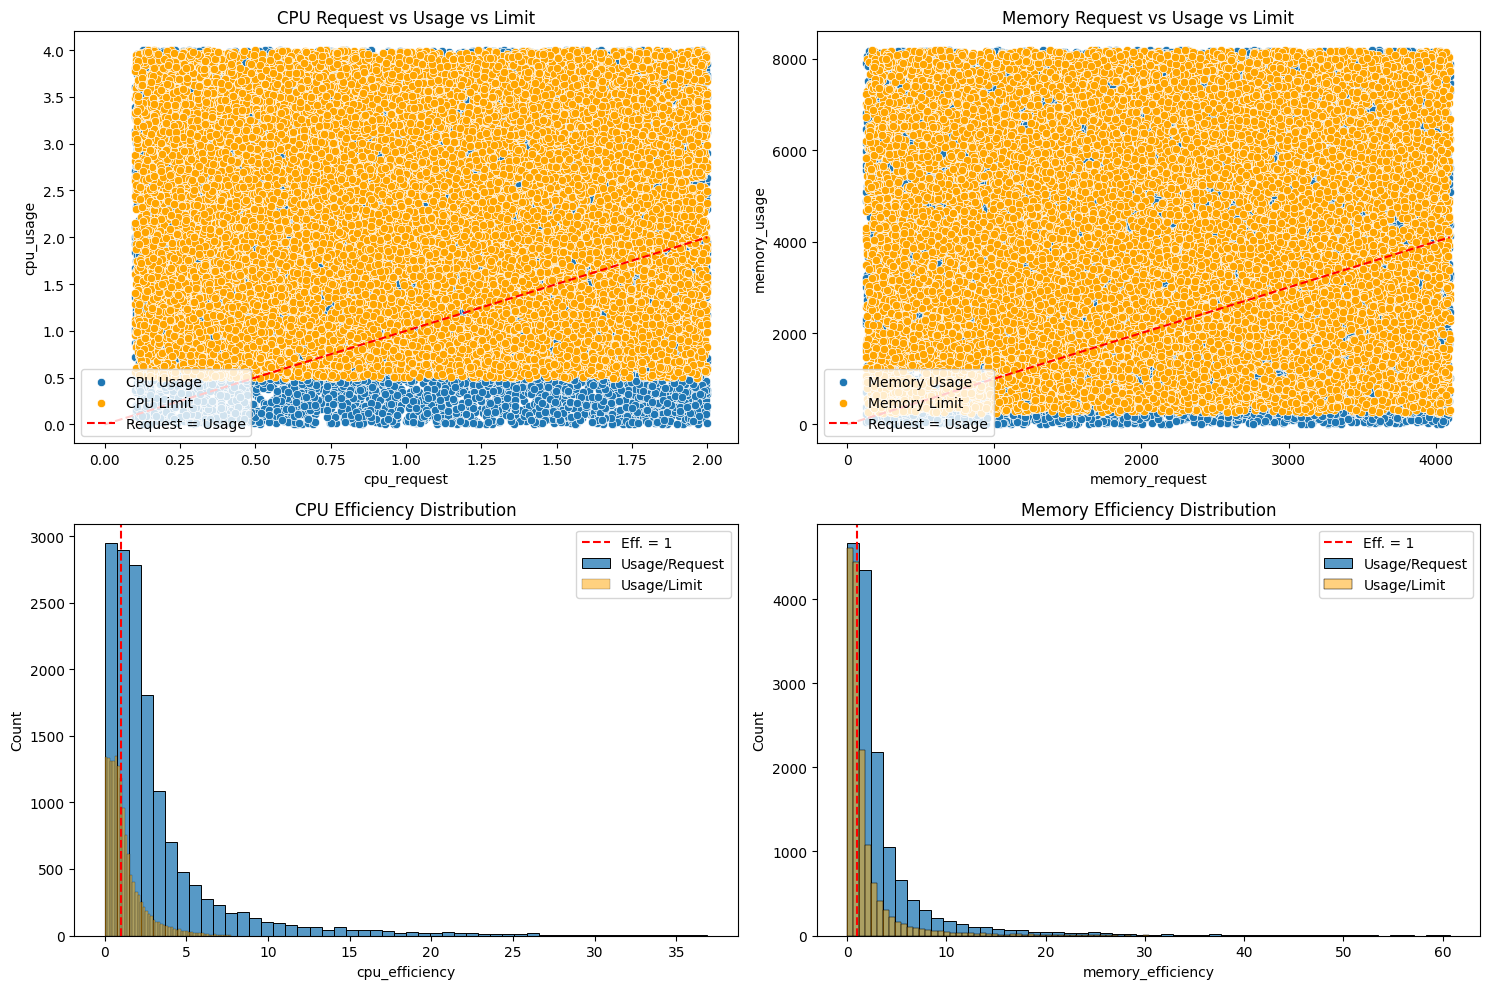

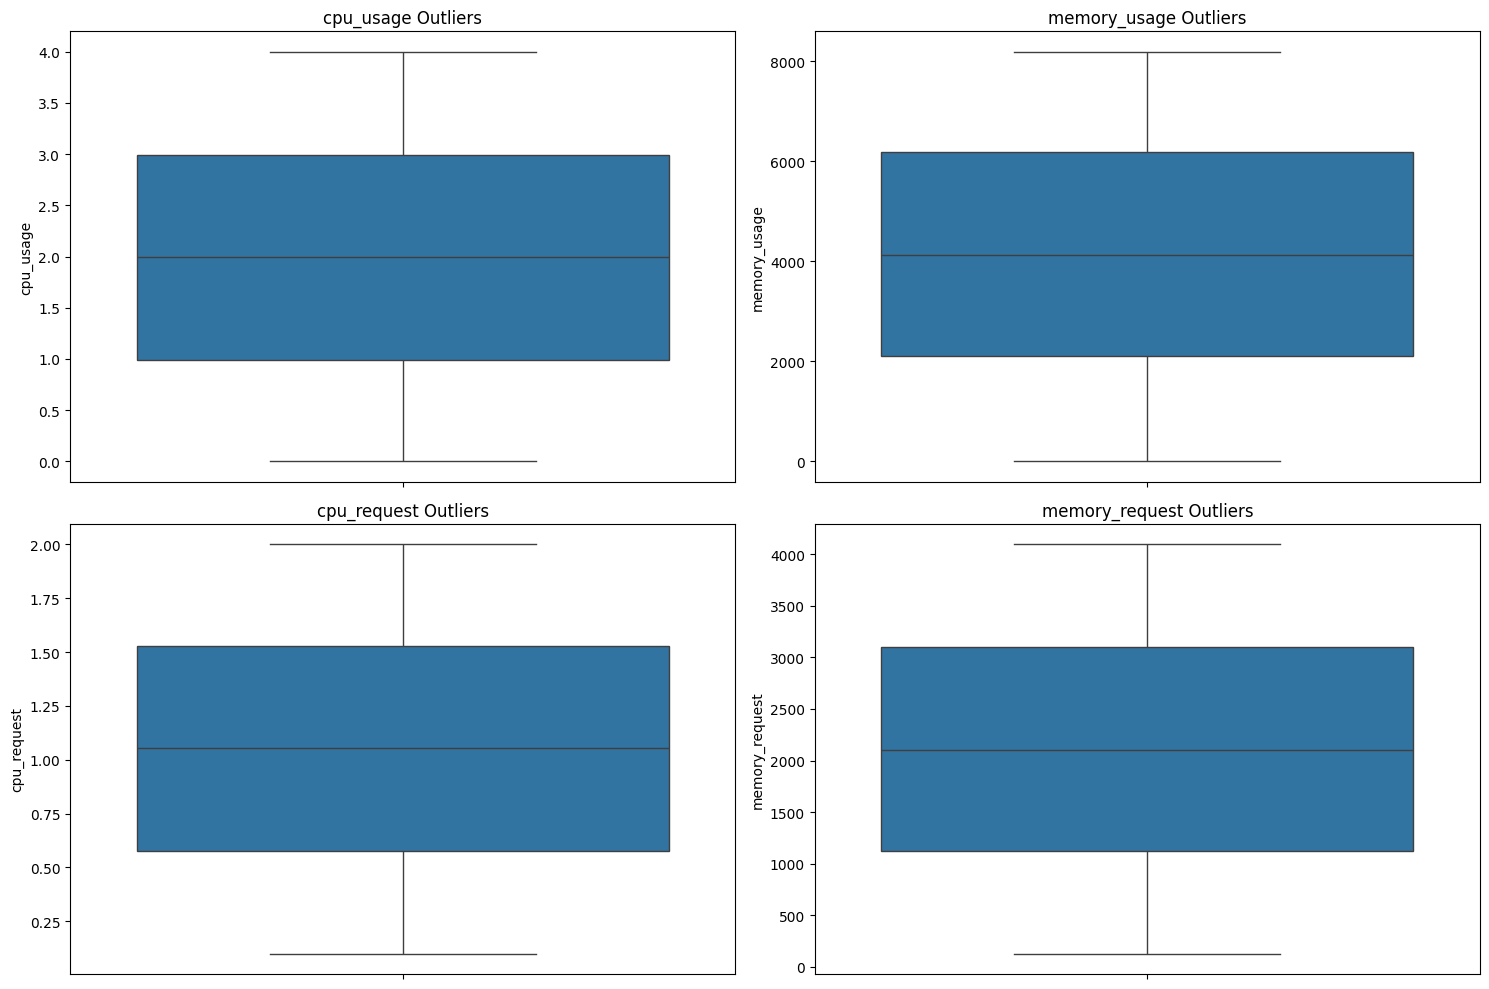


Resource Usage Summary:
                       Metrics        Values
0        CPU Efficiency (mean)      3.140878
1     Memory Efficiency (mean)      3.598411
2     Over-provisioned CPU (%)     13.526667
3  Over-provisioned Memory (%)     12.653333
4                   Total Pods  15000.000000
5            Unique Namespaces      4.000000

Namespace Distribution:
     Namespace  Distribution (%)
0  kube-system         25.513333
1         prod         25.140000
2          dev         24.980000
3      default         24.366667


In [2]:

os.makedirs('images/', exist_ok=True)

df = pd.read_csv('data/k8s_resources.csv')
metrics = ['cpu_request', 'cpu_limit', 'cpu_usage', 
          'memory_request', 'memory_limit', 'memory_usage']

def plot_resource_distributions(df, metrics):
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 3, i)
        sns.histplot(df[metric], kde=True)
        plt.title(f'{metric} Distribution')
    plt.tight_layout()
    plt.savefig('images/resource_distributions.png')
    plt.show()

plot_resource_distributions(df, metrics)

def plot_correlations(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation_matrix = df[numeric_cols].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Resource Metrics Correlation')
    plt.savefig('images/correlations.png')
    plt.show()

plot_correlations(df)

df['cpu_efficiency'] = df['cpu_usage'] / df['cpu_request']
df['memory_efficiency'] = df['memory_usage'] / df['memory_request']
df['cpu_limit_efficiency'] = df['cpu_usage'] / df['cpu_limit']
df['memory_limit_efficiency'] = df['memory_usage'] / df['memory_limit']

def plot_namespace_patterns(df):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    sns.boxplot(x='namespace', y='cpu_usage', data=df)
    plt.xticks(rotation=45)
    plt.title('CPU Usage by Namespace')
    
    plt.subplot(2, 2, 2)
    sns.boxplot(x='namespace', y='memory_usage', data=df)
    plt.xticks(rotation=45)
    plt.title('Memory Usage by Namespace')
    
    plt.subplot(2, 2, 3)
    sns.violinplot(x='namespace', y='cpu_efficiency', data=df)
    plt.xticks(rotation=45)
    plt.title('CPU Efficiency by Namespace')
    
    plt.subplot(2, 2, 4)
    sns.violinplot(x='namespace', y='memory_efficiency', data=df)
    plt.xticks(rotation=45)
    plt.title('Memory Efficiency by Namespace')
    
    plt.tight_layout()
    plt.savefig('images/namespace_patterns.png')
    plt.show()

plot_namespace_patterns(df)

def plot_resource_usage(df):
    plt.figure(figsize=(15, 10))
    
    # CPU Analysis
    plt.subplot(2, 2, 1)
    sns.scatterplot(x='cpu_request', y='cpu_usage', data=df, label='CPU Usage')
    sns.scatterplot(x='cpu_request', y='cpu_limit', data=df, label='CPU Limit', color='orange')
    plt.plot([0, df['cpu_request'].max()], [0, df['cpu_request'].max()], 'r--', label='Request = Usage')
    plt.title('CPU Request vs Usage vs Limit')
    plt.legend()
    
    # Memory Analysis
    plt.subplot(2, 2, 2)
    sns.scatterplot(x='memory_request', y='memory_usage', data=df, label='Memory Usage')
    sns.scatterplot(x='memory_request', y='memory_limit', data=df, label='Memory Limit', color='orange')
    plt.plot([0, df['memory_request'].max()], [0, df['memory_request'].max()], 'r--', label='Request = Usage')
    plt.title('Memory Request vs Usage vs Limit')
    plt.legend()
    
    # Efficiency Distributions
    plt.subplot(2, 2, 3)
    sns.histplot(df['cpu_efficiency'], bins=50, label='Usage/Request')
    sns.histplot(df['cpu_limit_efficiency'], bins=50, color='orange', label='Usage/Limit', alpha=0.5)
    plt.axvline(x=1, color='r', linestyle='--', label='Eff. = 1')
    plt.title('CPU Efficiency Distribution')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    sns.histplot(df['memory_efficiency'], bins=50, label='Usage/Request')
    sns.histplot(df['memory_limit_efficiency'], bins=50, color='orange', label='Usage/Limit', alpha=0.5)
    plt.axvline(x=1, color='r', linestyle='--', label='Eff. = 1')
    plt.title('Memory Efficiency Distribution')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('images/efficiency_metrics.png')
    plt.show()

plot_resource_usage(df)

def plot_outliers(df):
    metrics = ['cpu_usage', 'memory_usage', 'cpu_request', 'memory_request']
    
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        sns.boxplot(y=df[metric])
        plt.title(f'{metric} Outliers')
    
    plt.tight_layout()
    plt.savefig('images/outliers.png')
    plt.show()

plot_outliers(df)

def generate_summary(df):
    summary_dict = {
        'Metrics': [
            'CPU Efficiency (mean)',
            'Memory Efficiency (mean)',
            'Over-provisioned CPU (%)',
            'Over-provisioned Memory (%)',
            'Total Pods',
            'Unique Namespaces'
        ],
        'Values': [
            df['cpu_efficiency'].mean(),
            df['memory_efficiency'].mean(),
            (df['cpu_request'] > 2 * df['cpu_usage']).mean() * 100,
            (df['memory_request'] > 2 * df['memory_usage']).mean() * 100,
            len(df),
            df['namespace'].nunique()
        ]
    }
    
    summary_df = pd.DataFrame(summary_dict)
    namespace_dist = df['namespace'].value_counts(normalize=True).reset_index()
    namespace_dist.columns = ['Namespace', 'Distribution (%)']
    namespace_dist['Distribution (%)'] = namespace_dist['Distribution (%)'] * 100
    
    return summary_df, namespace_dist

summary_df, namespace_dist = generate_summary(df)
print("\nResource Usage Summary:")
print(summary_df)
print("\nNamespace Distribution:")
print(namespace_dist)

# Data Prep

In [3]:
def initial_cleanup(df):
        df = df.dropna(subset=[
            'cpu_request', 'cpu_limit', 'cpu_usage',
            'memory_request', 'memory_limit', 'memory_usage'
        ])
        df = df[df['cpu_request'] > 0]
        df = df[df['memory_request'] > 0]
        df = df[df['cpu_limit'] >= df['cpu_request']]
        df = df[df['memory_limit'] >= df['memory_request']]
initial_cleanup(df)

In [4]:
def engineer_features(df, le=None):
    """Engineer features for classification"""
    if le is None:
        le = LabelEncoder()
        
    features = pd.DataFrame()
    
    features['resource_efficiency'] = (df['cpu_usage'] / df['cpu_limit'] + 
                                    df['memory_usage'] / df['memory_limit']) / 2
    features['limit_ratio'] = df['cpu_limit'] / df['memory_limit']
    features['request_ratio'] = df['cpu_request'] / df['memory_request']
    features['usage_ratio'] = df['cpu_usage'] / df['memory_usage']    
    features['cpu_headroom'] = df['cpu_limit'] - df['cpu_usage']
    features['memory_headroom'] = df['memory_limit'] - df['memory_usage']
    features['cpu_efficiency'] = df['cpu_usage'] / df['cpu_request']
    features['memory_efficiency'] = df['memory_usage'] / df['memory_request']
    features['cpu_utilization_percent'] = (df['cpu_usage'] / df['cpu_limit']) * 100
    features['memory_utilization_percent'] = (df['memory_usage'] / df['memory_limit']) * 100
    features['cpu_request_utilization_percent'] = (df['cpu_usage'] / df['cpu_request']) * 100
    features['memory_request_utilization_percent'] = (df['memory_usage'] / df['memory_request']) * 100
    features['namespace_encoded'] = le.fit_transform(df['namespace'])
    
    return features, le

def create_target(df):
    return ((df['cpu_request'] > df['cpu_limit'] * 0.8) |
            (df['memory_request'] > df['memory_limit'] * 0.8) |
            (df['cpu_request'] < df['cpu_limit'] * 0.2) |
            (df['memory_request'] < df['memory_limit'] * 0.2)).astype(int)

def prepare_data(df):
    features, _ = engineer_features(df)
    target = create_target(df)
    
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=42, stratify=target
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    return X_train_scaled, X_test_scaled, y_train, y_test




# Initial Model

In [5]:
X_train, X_test, y_train, y_test = prepare_data(df)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
results = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, results))


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       902
           1       0.95      0.96      0.95      2098

    accuracy                           0.93      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.93      0.93      0.93      3000



# Model Optimization 

Cross-Validation Scores: [0.91625    0.92291667 0.93375    0.92208333 0.92208333]
Mean CV Accuracy: 0.9234166666666667
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


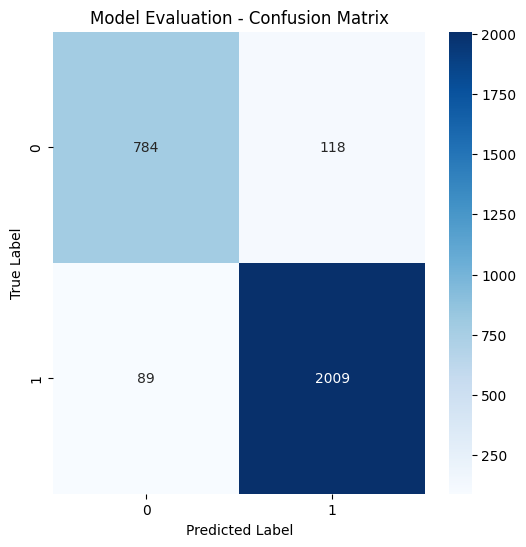

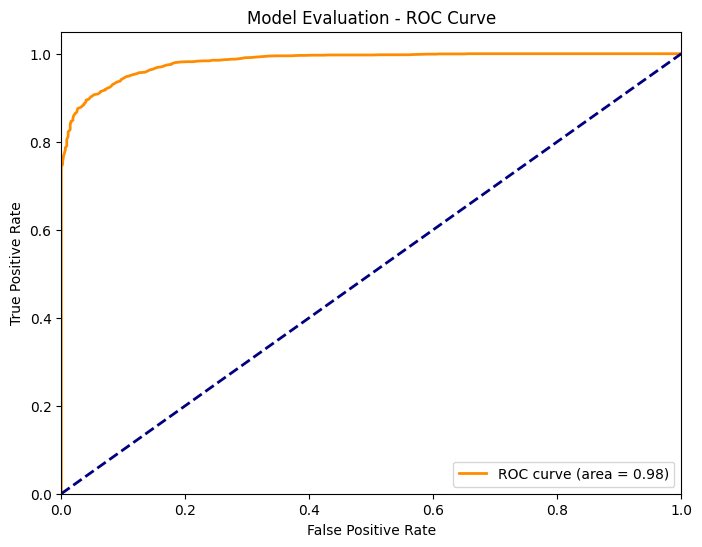

Feature Importances:
request_ratio: 0.1308
limit_ratio: 0.1113
memory_request_utilization_percent: 0.0896
memory_efficiency: 0.0880
resource_efficiency: 0.0864
cpu_request_utilization_percent: 0.0852
cpu_efficiency: 0.0843
memory_utilization_percent: 0.0807
cpu_utilization_percent: 0.0739
memory_headroom: 0.0653
cpu_headroom: 0.0638
usage_ratio: 0.0324
namespace_encoded: 0.0083


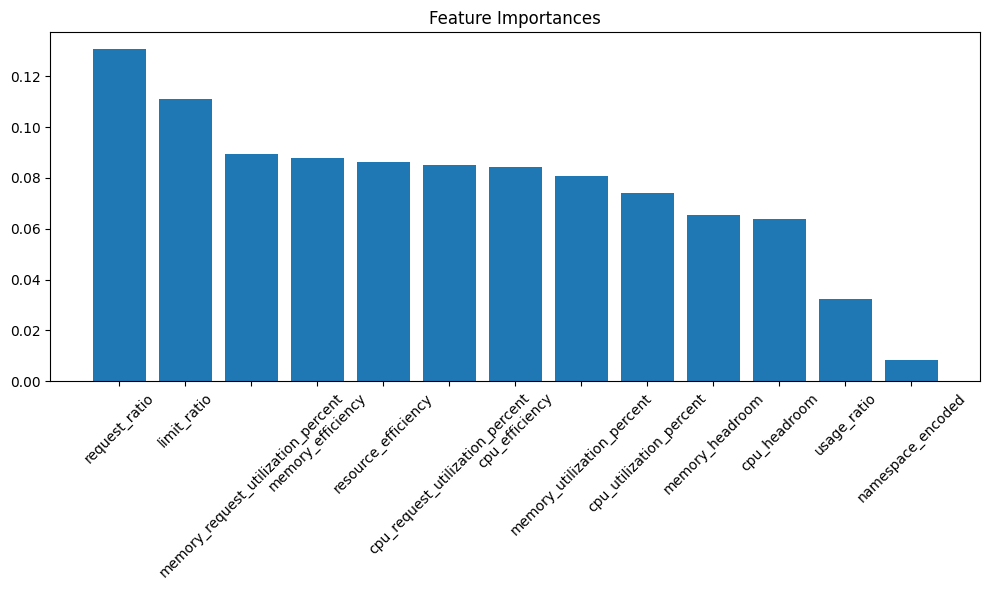


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       902
           1       0.94      0.96      0.95      2098

    accuracy                           0.93      3000
   macro avg       0.92      0.91      0.92      3000
weighted avg       0.93      0.93      0.93      3000



In [6]:
def perform_cross_validation(X_train, y_train, model, cv=5):
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f"Cross-Validation Scores: {scores}")
    print(f"Mean CV Accuracy: {scores.mean()}")
    return scores

def optimize_hyperparameters(X_train, y_train, param_grid):
    base_model = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(base_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print(f"Best Parameters: {grid_search.best_params_}")
    return RandomForestClassifier(**grid_search.best_params_, random_state=42)

def plot_model_evaluation(y_test, y_pred, y_prob, title='Model Evaluation'):
    # Confusion Matrix
    plt.figure(figsize=(6, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{title} - Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title} - ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    importance_pairs = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
    
    # Print feature importances
    print("Feature Importances:")
    for name, importance in importance_pairs:
        print(f"{name}: {importance:.4f}")
    
    plt.figure(figsize=(10, 6))
    names, values = zip(*importance_pairs)
    plt.bar(names, values)
    plt.xticks(rotation=45)
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show()

cv_scores = perform_cross_validation(X_train, y_train, model)
    
    # Hyperparameter optimization
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
optimized_model = optimize_hyperparameters(X_train, y_train, param_grid)

# Train and evaluate
optimized_model.fit(X_train, y_train)
y_pred = optimized_model.predict(X_test)
y_prob = optimized_model.predict_proba(X_test)[:, 1]

plot_model_evaluation(y_test, y_pred, y_prob)
plot_feature_importance(optimized_model, X_train.columns)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Anomaly Detection


Training Isolation Forest...

=== Evaluation Results for Isolation Forest ===
Precision: 0.26
Recall: 0.06
F1 Score: 0.10
ROC-AUC: 0.48


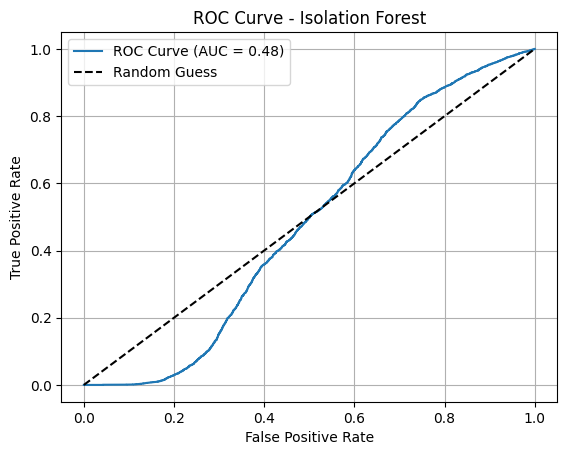

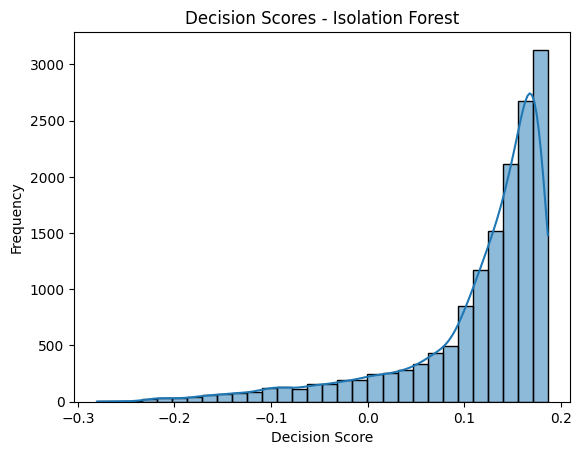

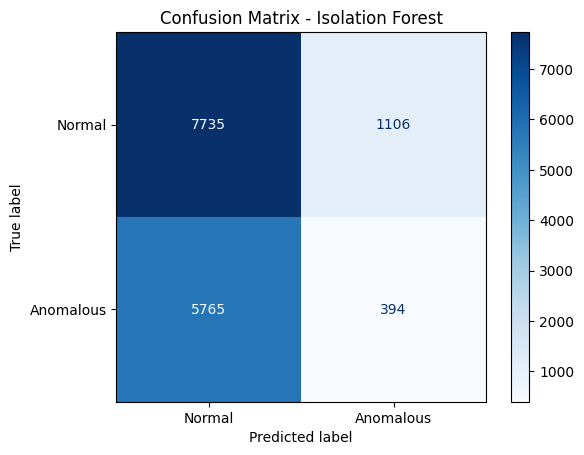


Training One-Class SVM...

=== Evaluation Results for One-Class SVM ===
Precision: 0.50
Recall: 0.12
F1 Score: 0.20
ROC-AUC: 0.21


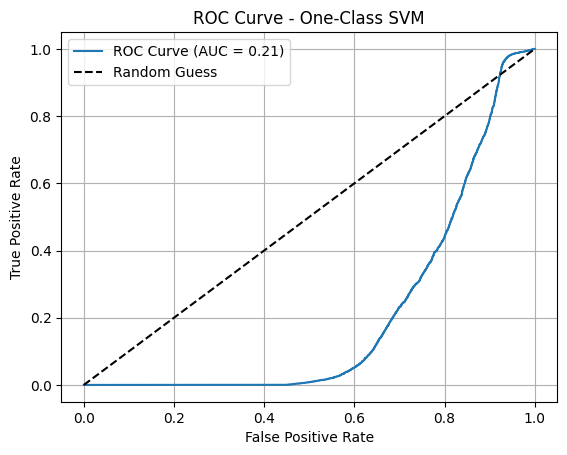

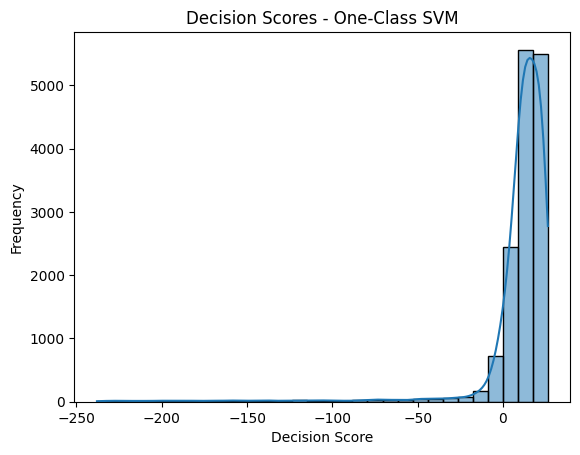

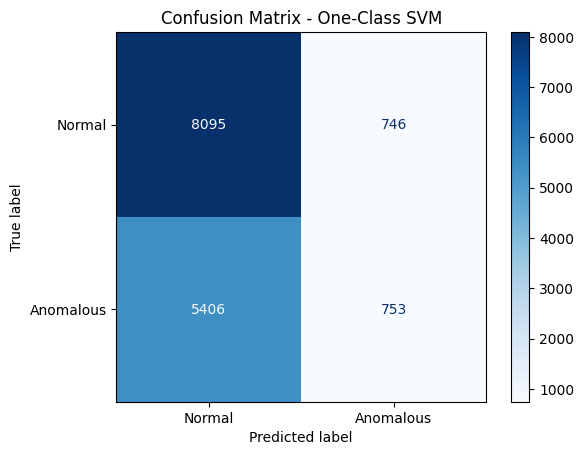

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def preprocess_data(df):
    df['cpu_efficiency'] = df['cpu_usage'] / df['cpu_request']
    df['memory_efficiency'] = df['memory_usage'] / df['memory_request']
    
    features = df[['cpu_efficiency', 'memory_efficiency']]
    
    # Scale features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    return scaled_features

def train_isolation_forest(X, contamination=0.1):
    model = IsolationForest(contamination=contamination, random_state=42)
    model.fit(X)
    return model

def train_one_class_svm(X, nu=0.1):
    model = OneClassSVM(kernel='rbf', nu=nu, gamma='scale')
    model.fit(X)
    return model

def evaluate_model(model, X, y_true, model_name):
    if model_name == "Isolation Forest":
        y_pred = model.predict(X)
        decision_scores = model.decision_function(X)
    elif model_name == "One-Class SVM":
        y_pred = model.predict(X)
        decision_scores = model.decision_function(X)
    else:
        raise ValueError("Unsupported model type")
    
    y_pred = np.where(y_pred == -1, 1, 0)
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, decision_scores)
    
    print(f"\n=== Evaluation Results for {model_name} ===")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC-AUC: {roc_auc:.2f}")
    
    fpr, tpr, _ = roc_curve(y_true, decision_scores)
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.savefig(f"roc_curve_{model_name.lower().replace(' ', '_')}.png")
    plt.show()

    sns.histplot(decision_scores, kde=True, bins=30)
    plt.title(f"Decision Scores - {model_name}")
    plt.xlabel("Decision Score")
    plt.ylabel("Frequency")
    plt.savefig(f"decision_scores_{model_name.lower().replace(' ', '_')}.png")
    plt.show()

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomalous"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.savefig(f"confusion_matrix_{model_name.lower().replace(' ', '_')}.png")
    plt.show()

def main():
  
    df = pd.read_csv("data/k8s_resources.csv")
    df = df[['cpu_request', 'cpu_usage', 'memory_request', 'memory_usage']]
    
    df['is_anomalous'] = ((df['cpu_usage'] / df['cpu_request'] < 0.9) | 
                          (df['memory_usage'] / df['memory_request'] < 0.9)).astype(int)
    
    X = preprocess_data(df)
    y_true = df['is_anomalous']
    
    print("\nTraining Isolation Forest...")
    isolation_forest = train_isolation_forest(X, contamination=0.1)
    evaluate_model(isolation_forest, X, y_true, "Isolation Forest")
    
    print("\nTraining One-Class SVM...")
    ocsvm = train_one_class_svm(X, nu=0.1)
    evaluate_model(ocsvm, X, y_true, "One-Class SVM")

if __name__ == "__main__":
    main()
